In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd

In [4]:
import celloracle as co

which: no R in (/ix/djishnu/alw399/envs/bee/bin:/ix/djishnu/alw399/envs/bee/bin:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/condabin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/lib/vscode/bin/remote-cli:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/bin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/bin:/ihome/crc/install/git/2.33.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/b

In [5]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
# base_GRN

In [6]:
import anndata
adata = anndata.read_h5ad('../data/slideseq/day3_1.h5ad')
adata.layers["raw_count"] = adata.X
adata

AnnData object with n_obs × n_vars = 15920 × 24649
    obs: 'cluster', 'rctd_cluster'
    uns: 'cluster_colors', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count'

In [7]:
n_top_genes = 4000 
min_cells = 10 #Minimum number of cells expressed required for a gene to pass filtering.
min_counts = 300 #Minimum number of counts required for a cell to pass filtering.
gene_min_counts = None #Minimum number of counts required for a gene to pass filtering.

adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
adata = adata[:, ~adata.var["mt"]]
sc.pp.filter_genes(adata, min_cells=min_cells, min_counts=gene_min_counts)

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 10277 × 4000
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'rctd_cluster_colors', 'log1p', 'hvg'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count'

In [8]:
import sys
sys.path.append('../src')

import numpy as np
# from utils import adata_train

import scanpy as sc 
adata = sc.read_h5ad('./.cache/adata_train.h5ad')
adata

AnnData object with n_obs × n_vars = 10277 × 2833
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'rctd_celltypes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'hvg', 'log1p', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'spatial_maps'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [9]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

2024-09-04 22:30:45.209680: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 22:30:45.441065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 22:30:45.675306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 22:30:45.784348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 22:30:46.031583: I tensorflow/core/platform/cpu_feature_guar

CPU times: user 36.4 s, sys: 4.27 s, total: 40.6 s
Wall time: 43.1 s


In [10]:
sc.tl.paga(adata, groups='rctd_cluster')

In [11]:
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

In [12]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

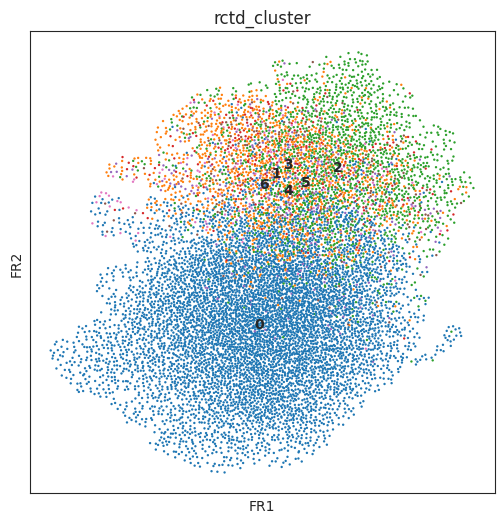

In [13]:
%matplotlib inline
sc.pl.draw_graph(adata, color='rctd_cluster', legend_loc='on data')

In [14]:
oracle = co.Oracle()

In [15]:
adata.layers["raw_count"].toarray().sum(0)

array([272.1245  ,  37.495457, 299.18042 , ..., 125.623566, 165.64575 ,
       191.23195 ], dtype=float32)

In [16]:
adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="rctd_cluster",
    embedding_name="X_draw_graph_fr"
)

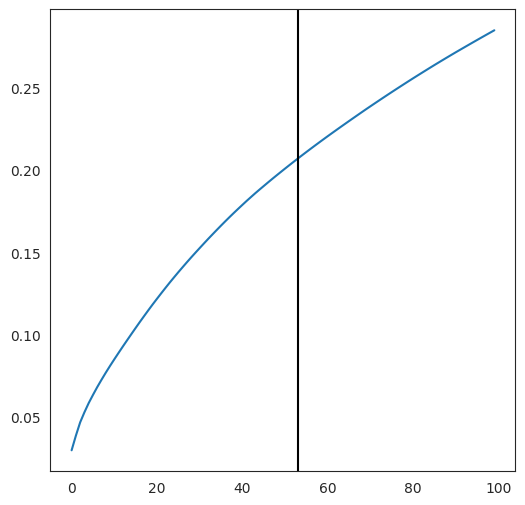

53


In [17]:
%matplotlib inline

# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [18]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :10277


In [19]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :256


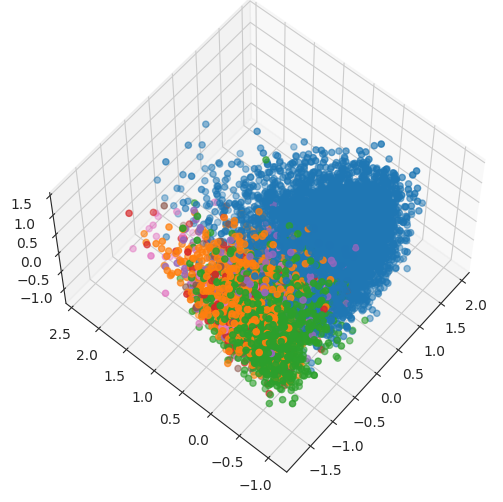

In [20]:
oracle.plot_pca()

In [21]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [22]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [23]:
adata.obsm['X_pca'].shape

(10277, 50)

In [24]:
adata.obs['rctd_cluster'].value_counts()

0    6604
2    1686
1    1155
4     283
3     227
5     191
6     131
Name: rctd_cluster, dtype: int64

In [25]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="rctd_cluster", 
    alpha=10,
    verbose_level=10
)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 1...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 2...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 3...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 4...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 5...


  0%|          | 0/2363 [00:00<?, ?it/s]

Inferring GRN for 6...


  0%|          | 0/2363 [00:00<?, ?it/s]

CPU times: user 14min 40s, sys: 18 s, total: 14min 58s
Wall time: 19min 4s


In [26]:
links.links_dict[0][links.links_dict[0].p < 0.05].query('target=="Il2"').reset_index(drop=True).sort_values(by='coef_mean', ascending=False)

,source,target,coef_mean,coef_abs,p,-logp
1,Smc3,Il2,0.000307,0.000307,1.270810e-11,10.895919
3,Rest,Il2,0.000090,0.000090,4.375393e-05,4.358983
2,Msc,Il2,0.000050,0.000050,5.835973e-04,3.233887
0,Mga,Il2,0.000050,0.000050,5.280426e-03,2.277331


In [28]:
links.links_dict[0].query('target=="Il2ra"')

,source,target,coef_mean,coef_abs,p,-logp
45545,Zbtb6,Il2ra,0.000182,0.000182,4.848792e-07,6.314366
45546,Runx2,Il2ra,0.001389,0.001389,1.410561e-10,9.850608
45547,Foxj3,Il2ra,0.000388,0.000388,4.611046e-12,11.336201
45548,Nfib,Il2ra,-0.000152,0.000152,9.467253e-03,2.023776
45549,Taf1,Il2ra,0.000799,0.000799,6.623689e-10,9.178900
45550,Smad1,Il2ra,-0.000057,0.000057,2.114629e-01,0.674766
45551,Erg,Il2ra,-0.000361,0.000361,1.773215e-06,5.751239
45552,Pax5,Il2ra,-0.003931,0.003931,6.840333e-07,6.164923
45553,Hivep1,Il2ra,0.000529,0.000529,5.973916e-14,13.223741
45554,Foxn3,Il2ra,0.001061,0.001061,5.357533e-06,5.271035


In [ ]:
import pickle

with open('../data/slideseq/celloracle_links_day3_1.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [ ]:
import pickle

with open('/Users/koush/Projects/SpaceOracle/data/slideseq/celloracle_links_day3_1.pkl', 'rb') as f:
    links_day3_1 = pickle.load(f)

with open('/Users/koush/Projects/SpaceOracle/data/slideseq/celloracle_links_day3_2.pkl', 'rb') as f:
    links_day3_2 = pickle.load(f)

In [ ]:
regulators = pd.concat(
    [list(links_day3_1.values())[x].query('target=="Cd74" and p < 0.05')[['source', 'coef_mean']] 
        for x in range(len(links_day3_1))], axis=0)

In [ ]:
(regulators
    .groupby('source')
    .mean()
    .sort_values(by='coef_mean', ascending=False)).index.tolist()

['Pax5',
 'Mef2c',
 'Bcl11a',
 'Ebf1',
 'Pou2f2',
 'Irf9',
 'Tbp',
 'Stat2',
 'Tal1',
 'Myc',
 'Rreb1',
 'Ebf3',
 'Rxra',
 'Foxj3',
 'Taf1',
 'Tcf7l2',
 'Hivep1',
 'Atf3',
 'Klf7',
 'Zkscan1',
 'Gata2',
 'Mef2a',
 'Egr2',
 'Egr1']

<AxesSubplot: xlabel='source'>

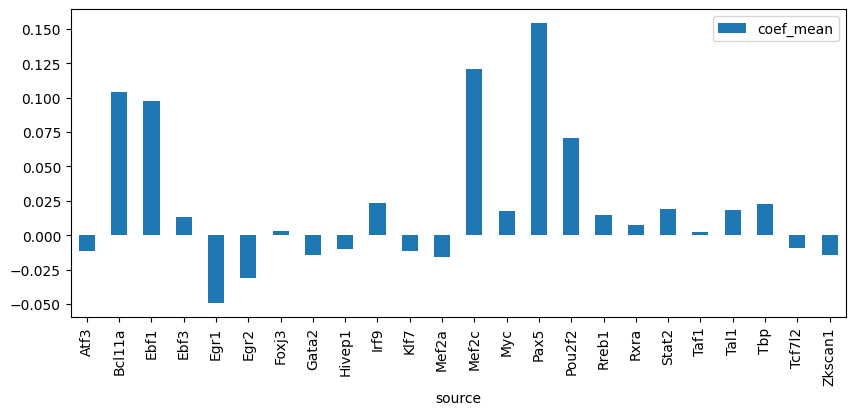

In [ ]:
plt.rcParams["figure.figsize"] = [10, 4]
df.groupby('source').mean().plot(kind='bar')

In [ ]:
pd.DataFrame(
    [df2.set_index('target').loc[np.intersect1d(
        df1.target, df2.target)].coef_mean-df1.set_index('target').loc[
     np.intersect1d(df1.target, df2.target)].coef_mean]).T.sort_values(by='coef_mean', ascending=False)[:20]

,coef_mean
target,
Ccl5,0.031504
Rps24,0.027042
Lgals1,0.024633
Cd74,0.023614
Iglc3,0.018855
Smc4,0.015679
Epsti1,0.015348
Lyz2,0.014656
Clu,0.011830


In [ ]:
oracle = co.data.load_tutorial_oracle_object()

/Users/koush/Projects/SpaceOracle/notebooks/../src/celloracle/utility/hdf5_processing.py:41: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  return pickle.loads(zlib.decompress(uint.tobytes()))
/Users/koush/Projects/SpaceOracle/notebooks/../src/celloracle/utility/hdf5_processing.py:41: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  return pickle.loads(zlib.decompress(uint.tobytes()))
/Users/koush/Projects/SpaceOracle/notebooks/../src/celloracle/utility/hdf5_processing.py:41: DeprecationWarning: Please import `coo_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.coo` namespace is deprecated and will be removed in SciPy 2.0.0.
  return pickle.loads(zlib.decompress(uint.tobytes()))


In [ ]:
oracle.adata.obs['paul15_clusters'].unique()

['7MEP', '15Mo', '3Ery', '4Ery', '2Ery', ..., '6Ery', '12Baso', '18Eos', '11DC', '19Lymph']
Length: 19
Categories (19, object): ['1Ery', '2Ery', '3Ery', '4Ery', ..., '16Neu', '17Neu', '18Eos', '19Lymph']

In [ ]:
oracle.adata

AnnData object with n_obs × n_vars = 2671 × 1999
    obs: 'paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot', 'Lineage_MEP', 'Lineage_GMP', 'Pseudotime_Lineage_MEP', 'Pseudotime_Lineage_GMP', 'Pseudotime'
    var: 'n_counts', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
    uns: 'cell_type_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'louvain_annot_colors', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca', 'log1p'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    layers: 'raw_count', 'normalized_count', 'imputed_count', 'simulation_input'
    obsp: 'connectivities', 'distances'

In [ ]:
mat = pd.read_csv("coef_matrix.csv", index_col=0)

In [ ]:
# oracle.TFdict

In [ ]:
np.intersect1d(mat.columns, list(oracle.TFdict.keys())).__len__()

1850

In [ ]:
np.intersect1d(mat.columns, list(oracle.TFdict.keys()))

array(['0610007L01Rik', '0610010K14Rik', '0910001L09Rik', ..., 'Zmynd11',
       'Zswim4', 'Zyx'], dtype=object)

In [ ]:
mat['Zyx'][mat['Zyx'] > 0]

Chd2     0.061002
Elf1     0.001180
Ets1     0.008602
Fli1     0.030356
Id2      0.007249
Klf6     0.019745
Mef2c    0.027569
Mycn     0.009732
Nfe2     0.138767
Nfkb1    0.040420
Rel      0.002212
Stat3    0.066046
Zbtb4    0.000165
Name: Zyx, dtype: float64

In [ ]:
np.intersect1d(mat.columns, oracle.TFdict['Zyx'])

array(['Batf3', 'Chd2', 'Cxxc1', 'E2f4', 'Egr1', 'Elf1', 'Ets1', 'Fli1',
       'Hnf4a', 'Id2', 'Irf1', 'Klf1', 'Klf2', 'Klf4', 'Klf6', 'Mef2c',
       'Myc', 'Mycn', 'Nfe2', 'Nfia', 'Nfic', 'Nfkb1', 'Nr3c1', 'Prdm5',
       'Rel', 'Rreb1', 'Smarca5', 'Smarcc1', 'Smarcc2', 'Stat1', 'Stat3',
       'Stat5a', 'Zbtb1', 'Zbtb4', 'Zbtb7a'], dtype=object)

In [ ]:
np.intersect1d(oracle.adata.var_names, oracle.TFdict['0610007L01Rik'])

array(['Chd2', 'E2f4', 'Egr1', 'Elf1', 'Ets1', 'Fli1', 'Foxp1', 'Gata1',
       'Gata2', 'Hnf4a', 'Id2', 'Irf7', 'Klf2', 'Klf6', 'Mef2c', 'Myc',
       'Mycn', 'Nfe2', 'Nfkb1', 'Rara', 'Runx1', 'Stat1', 'Stat3',
       'Stat4', 'Stat5a', 'Zbtb1', 'Zbtb7a'], dtype=object)

In [ ]:
oracle.fit_GRN_for_simulation()

  0%|          | 0/24 [00:00<?, ?it/s]

['Hnf4a', 'Stat1', 'Mef2c', 'Elf1', 'Id2', 'Mycn', 'Zbtb7a', 'Rara', 'Klf6', 'Fli1', 'Runx1', 'Zbtb1', 'Nfe2', 'Gata1', 'Nfkb1', 'Irf7', 'Ets1', 'Stat4', 'Gata2', 'E2f4', 'Foxp1', 'Chd2', 'Egr1', 'Stat3', 'Stat5a', 'Klf2', 'Myc'] 0610007L01Rik
['Bptf', 'Hnf4a', 'Nfia', 'Zbtb4', 'Elk3', 'Rreb1', 'Spi1', 'Nfatc3', 'Stat1', 'Brf1', 'Mef2c', 'Prdm5', 'Elf1', 'Hivep2', 'Id2', 'Mycn', 'Klf4', 'Cxxc1', 'Smarca5', 'Zbtb7a', 'Klf1', 'Etv6', 'Nr3c1', 'Cebpa', 'Ikzf2', 'Irf2', 'Fli1', 'Klf6', 'Rara', 'Nfe2', 'Batf3', 'Nfatc2', 'Runx1', 'Zbtb1', 'Herpud1', 'Irf8', 'Gata1', 'Irf1', 'Foxo1', 'Nfe2l2', 'Runx2', 'Nfkb1', 'Irf7', 'Ets1', 'Pbx1', 'Smarcc2', 'Stat4', 'Lmo2', 'Gata2', 'Nfya', 'Cux1', 'Tcfec', 'E2f4', 'Nfic', 'Bcl11a', 'Bdp1', 'Foxp1', 'Rel', 'Ybx1', 'Chd2', 'Myb', 'Itgb2', 'Hoxa5', 'Egr1', 'Smarcc1', 'Bhlha15', 'Stat3', 'Stat5a', 'Klf2', 'Myc', 'Nfat5'] 0610010K14Rik
['Zbtb4', 'Irf9', 'Rreb1', 'Spi1', 'Stat1', 'Id2', 'Mycn', 'Klf4', 'Zbtb7a', 'Rara', 'Nr3c1', 'Klf6', 'Irf2', 'Fli1', 'Runx

KeyboardInterrupt: 